In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import json
from datetime import datetime
from torch.nn.utils import clip_grad_norm_


# Import from previous notebooks
# (Use %run or import directly if you've created Python modules)
%run "01-data-preperation.ipynb"  # For data loaders
%run "02-model-implementation.ipynb"  # For model definitions

# Set up directories for saving results
base_dir = "results"
model_dir = os.path.join(base_dir, "models")
log_dir = os.path.join(base_dir, "logs")
plot_dir = os.path.join(base_dir, "plots")

# Create directories if they don't exist
os.makedirs(model_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

Using device: cuda:0
Dataset loaded with 45000 training, 5000 validation, and 10000 test images.
Number of classes: 10
Testing Baseline CNN:
Forward pass successful!
Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])

Testing SE-CNN:
Forward pass successful!
Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])

Testing CBAM-CNN:
Forward pass successful!
Input shape: torch.Size([1, 3, 32, 32])
Output shape: torch.Size([1, 10])

Parameter Counts:
Baseline CNN: 259,338 parameters
SE-CNN: 264,074 parameters
CBAM-CNN: 264,466 parameters

SE-CNN has 1.83% more parameters than baseline
CBAM-CNN has 1.98% more parameters than baseline
Using device: cuda


In [3]:
# Define hyperparameters
config = {
    # Common training parameters
    "num_epochs": 50,
    "batch_size": 128,
    "learning_rate": 0.01,  # Higher learning rate often works well for CIFAR-10
    "weight_decay": 5e-4,  # Standard for CIFAR-10
    "early_stopping_patience": 15,
    "scheduler_step_size": 30,
    "scheduler_gamma": 0.1,
    
    # Model-specific parameters (can be adjusted per model if needed)
    "baseline": {
        "dropout": 0.3,  # Lower dropout often works better for CIFAR-10
    },
    "se": {
        "dropout": 0.3,
        "reduction_ratio": 16,
    },
    "cbam": {
        "dropout": 0.3,
        "reduction_ratio": 16,
        "spatial_kernel_size": 7,
    }
}

# Save configuration for reproducibility
with open(os.path.join(log_dir, "config.json"), "w") as f:
    json.dump(config, f, indent=4)

In [4]:
def train_one_epoch(model, dataloader, criterion, optimizer, scheduler=None, clip_value=None, device='cuda'):
    """
    Train for one epoch with enhanced metrics and monitoring
    
    Args:
        model: The neural network model
        dataloader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler (optional)
        clip_value: Gradient clipping threshold (optional)
        device: Device to use for training ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing all metrics
    """
    model.train()
    start_time = time.time()
    
    running_loss = 0.0
    running_corrects = 0
    running_top5_corrects = 0
    processed_size = 0
    batch_times = []
    grad_norms = []
    
    # Get initial memory usage
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
    
    for inputs, labels in tqdm(dataloader, desc="Training"):
        batch_start = time.time()
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # Calculate top-5 accuracy
        _, top5_preds = torch.topk(outputs, 5, dim=1)
        correct_top5 = 0
        for i, label in enumerate(labels):
            correct_top5 += (label == top5_preds[i]).any().item()
        
        # Backward pass and optimize
        loss.backward()
        
        # Track gradient norms
        total_norm = 0
        for p in model.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        grad_norms.append(total_norm)
        
        # Apply gradient clipping if specified
        if clip_value is not None:
            clip_grad_norm_(model.parameters(), clip_value)
        
        optimizer.step()
        
        # Update learning rate if scheduler is provided
        if scheduler is not None and isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
            scheduler.step()
            
        # Statistics
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        running_corrects += torch.sum(preds == labels.data).item()
        running_top5_corrects += correct_top5
        processed_size += batch_size
        
        # Track batch processing time
        batch_times.append(time.time() - batch_start)
    
    # Calculate metrics
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    epoch_top5_acc = running_top5_corrects / processed_size
    epoch_time = time.time() - start_time
    avg_batch_time = np.mean(batch_times)
    avg_grad_norm = np.mean(grad_norms)
    
    # Calculate peak memory usage
    peak_memory = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
    memory_usage = peak_memory - initial_memory
    
    # Update learning rate for epoch-based schedulers
    if scheduler is not None and not isinstance(scheduler, torch.optim.lr_scheduler.OneCycleLR):
        scheduler.step()
    
    # Return all metrics
    metrics = {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'top5_acc': epoch_top5_acc,
        'time': epoch_time,
        'avg_batch_time': avg_batch_time,
        'memory_usage': memory_usage,
        'avg_grad_norm': avg_grad_norm,
        'current_lr': optimizer.param_groups[0]['lr']
    }
    
    return metrics


def evaluate(model, dataloader, criterion, device='cuda'):
    """
    Evaluate the model with enhanced metrics
    
    Args:
        model: The neural network model
        dataloader: Validation/test data loader
        criterion: Loss function
        device: Device to use for evaluation ('cuda' or 'cpu')
        
    Returns:
        dict: Dictionary containing all metrics
    """
    model.eval()
    start_time = time.time()
    
    running_loss = 0.0
    running_corrects = 0
    running_top5_corrects = 0
    processed_size = 0
    
    # Store predictions and targets for confusion matrix
    all_preds = []
    all_labels = []
    class_correct = {}
    class_total = {}
    
    # Get initial memory usage
    initial_memory = torch.cuda.memory_allocated() if torch.cuda.is_available() else 0
    
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Measure inference time
            inf_start = time.time()
            outputs = model(inputs)
            inference_times.append(time.time() - inf_start)
            
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Calculate top-5 accuracy
            _, top5_preds = torch.topk(outputs, 5, dim=1)
            correct_top5 = 0
            for i, label in enumerate(labels):
                correct_top5 += (label == top5_preds[i]).any().item()
            
            # Track predictions for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Class-wise accuracy
            for i in range(len(labels)):
                label = labels[i].item()
                if label not in class_correct:
                    class_correct[label] = 0
                    class_total[label] = 0
                
                class_total[label] += 1
                if preds[i] == label:
                    class_correct[label] += 1
            
            # Statistics
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            running_corrects += torch.sum(preds == labels.data).item()
            running_top5_corrects += correct_top5
            processed_size += batch_size
    
    # Calculate metrics
    epoch_loss = running_loss / processed_size
    epoch_acc = running_corrects / processed_size
    epoch_top5_acc = running_top5_corrects / processed_size
    epoch_time = time.time() - start_time
    avg_inference_time = np.mean(inference_times)
    
    # Calculate class-wise accuracy
    class_accuracy = {class_id: (class_correct.get(class_id, 0) / class_total.get(class_id, 1)) 
                     for class_id in class_total.keys()}
    
    # Calculate peak memory usage
    peak_memory = torch.cuda.max_memory_allocated() if torch.cuda.is_available() else 0
    memory_usage = peak_memory - initial_memory
    
    # Return all metrics
    metrics = {
        'loss': epoch_loss,
        'acc': epoch_acc,
        'top5_acc': epoch_top5_acc,
        'time': epoch_time,
        'avg_inference_time': avg_inference_time,
        'memory_usage': memory_usage,
        'class_accuracy': class_accuracy,
        'predictions': all_preds,
        'ground_truth': all_labels
    }
    
    return metrics

In [5]:
def train_model(model, train_loader, val_loader, model_name, config, device):
    """
    Complete training pipeline with logging and early stopping
    
    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        model_name: Name of the model (for saving)
        config: Configuration dictionary
        device: Device to train on
        
    Returns:
        model: Trained model
        history: Dictionary containing training history
    """
    # Initialize model
    model = model.to(device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config["learning_rate"], 
        weight_decay=config["weight_decay"]
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=config["scheduler_step_size"], 
        gamma=config["scheduler_gamma"]
    )
    
    # Initialize history dictionary
    history = {
        'train_loss': [], 'train_acc': [], 'train_top5_acc': [],
        'val_loss': [], 'val_acc': [], 'val_top5_acc': [],
        'learning_rate': []
    }
    
    # Early stopping variables
    best_val_acc = 0
    patience_counter = 0
    
    # Training loop
    for epoch in range(config["num_epochs"]):
        print(f"Epoch {epoch+1}/{config['num_epochs']}")
        
        # Train for one epoch
        train_metrics = train_one_epoch(
            model, train_loader, criterion, optimizer, 
            scheduler, device=device
        )
        
        # Evaluate on validation set
        val_metrics = evaluate(model, val_loader, criterion, device=device)
        
        # Update history
        history['train_loss'].append(train_metrics['loss'])
        history['train_acc'].append(train_metrics['acc'])
        history['train_top5_acc'].append(train_metrics['top5_acc'])
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['acc'])
        history['val_top5_acc'].append(val_metrics['top5_acc'])
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch results
        print(f"Train Loss: {train_metrics['loss']:.4f}, Acc: {train_metrics['acc']:.4f}, Top-5: {train_metrics['top5_acc']:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['acc']:.4f}, Top-5: {val_metrics['top5_acc']:.4f}")
        
        # Check for improvement
        if val_metrics['acc'] > best_val_acc:
            best_val_acc = val_metrics['acc']
            patience_counter = 0
            
            # Save the best model
            torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}_best.pth"))
            print(f"Saved best model with validation accuracy: {best_val_acc:.4f}")
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")
        
        # Early stopping
        if patience_counter >= config["early_stopping_patience"]:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break
    
    # Save final model and history
    torch.save(model.state_dict(), os.path.join(model_dir, f"{model_name}_final.pth"))
    with open(os.path.join(log_dir, f"{model_name}_history.json"), "w") as f:
        json.dump(history, f)
    
    # Load best model
    model.load_state_dict(torch.load(os.path.join(model_dir, f"{model_name}_best.pth")))
    
    return model, history

In [5]:
# 5.1 Train Baseline CNN
print("=== Training Baseline CNN ===")
baseline_model = BaselineCNN(num_classes=10)
baseline_model, baseline_history = train_model(
    baseline_model, trainloader, valloader, 
    "baseline", config, device
)

=== Training Baseline CNN ===
Epoch 1/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6768, Acc: 0.3562, Top-5: 0.8799
Val Loss: 2.7483, Acc: 0.2524, Top-5: 0.7936
Saved best model with validation accuracy: 0.2524
Epoch 2/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.3618, Acc: 0.5041, Top-5: 0.9351
Val Loss: 1.4227, Acc: 0.4944, Top-5: 0.9342
Saved best model with validation accuracy: 0.4944
Epoch 3/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.2157, Acc: 0.5682, Top-5: 0.9470
Val Loss: 1.2441, Acc: 0.5490, Top-5: 0.9428
Saved best model with validation accuracy: 0.5490
Epoch 4/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.1394, Acc: 0.5967, Top-5: 0.9549
Val Loss: 1.1602, Acc: 0.5958, Top-5: 0.9398
Saved best model with validation accuracy: 0.5958
Epoch 5/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0830, Acc: 0.6163, Top-5: 0.9606
Val Loss: 1.1797, Acc: 0.5884, Top-5: 0.9388
No improvement for 1 epochs
Epoch 6/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0460, Acc: 0.6330, Top-5: 0.9627
Val Loss: 1.1851, Acc: 0.5862, Top-5: 0.9556
No improvement for 2 epochs
Epoch 7/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0273, Acc: 0.6406, Top-5: 0.9625
Val Loss: 1.2254, Acc: 0.5872, Top-5: 0.9332
No improvement for 3 epochs
Epoch 8/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0119, Acc: 0.6507, Top-5: 0.9648
Val Loss: 1.1449, Acc: 0.5942, Top-5: 0.9530
No improvement for 4 epochs
Epoch 9/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9864, Acc: 0.6571, Top-5: 0.9651
Val Loss: 1.0071, Acc: 0.6442, Top-5: 0.9602
Saved best model with validation accuracy: 0.6442
Epoch 10/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9722, Acc: 0.6641, Top-5: 0.9674
Val Loss: 1.1314, Acc: 0.5986, Top-5: 0.9568
No improvement for 1 epochs
Epoch 11/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9637, Acc: 0.6696, Top-5: 0.9684
Val Loss: 0.9650, Acc: 0.6628, Top-5: 0.9658
Saved best model with validation accuracy: 0.6628
Epoch 12/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9588, Acc: 0.6725, Top-5: 0.9669
Val Loss: 1.1747, Acc: 0.5972, Top-5: 0.9544
No improvement for 1 epochs
Epoch 13/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9411, Acc: 0.6784, Top-5: 0.9689
Val Loss: 1.0387, Acc: 0.6284, Top-5: 0.9578
No improvement for 2 epochs
Epoch 14/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9418, Acc: 0.6793, Top-5: 0.9677
Val Loss: 1.0701, Acc: 0.6298, Top-5: 0.9552
No improvement for 3 epochs
Epoch 15/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9358, Acc: 0.6785, Top-5: 0.9685
Val Loss: 1.0435, Acc: 0.6424, Top-5: 0.9686
No improvement for 4 epochs
Epoch 16/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9268, Acc: 0.6839, Top-5: 0.9690
Val Loss: 0.9570, Acc: 0.6622, Top-5: 0.9704
No improvement for 5 epochs
Epoch 17/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9214, Acc: 0.6873, Top-5: 0.9679
Val Loss: 0.9560, Acc: 0.6708, Top-5: 0.9696
Saved best model with validation accuracy: 0.6708
Epoch 18/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9120, Acc: 0.6919, Top-5: 0.9702
Val Loss: 0.9142, Acc: 0.6726, Top-5: 0.9742
Saved best model with validation accuracy: 0.6726
Epoch 19/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9164, Acc: 0.6859, Top-5: 0.9708
Val Loss: 0.9336, Acc: 0.6692, Top-5: 0.9736
No improvement for 1 epochs
Epoch 20/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9127, Acc: 0.6900, Top-5: 0.9698
Val Loss: 0.9264, Acc: 0.6784, Top-5: 0.9710
Saved best model with validation accuracy: 0.6784
Epoch 21/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9125, Acc: 0.6912, Top-5: 0.9690
Val Loss: 0.9127, Acc: 0.6798, Top-5: 0.9754
Saved best model with validation accuracy: 0.6798
Epoch 22/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9048, Acc: 0.6945, Top-5: 0.9689
Val Loss: 1.0701, Acc: 0.6364, Top-5: 0.9586
No improvement for 1 epochs
Epoch 23/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9042, Acc: 0.6928, Top-5: 0.9706
Val Loss: 0.9790, Acc: 0.6534, Top-5: 0.9718
No improvement for 2 epochs
Epoch 24/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8934, Acc: 0.6944, Top-5: 0.9711
Val Loss: 1.0016, Acc: 0.6528, Top-5: 0.9690
No improvement for 3 epochs
Epoch 25/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8878, Acc: 0.6998, Top-5: 0.9716
Val Loss: 1.1178, Acc: 0.6378, Top-5: 0.9438
No improvement for 4 epochs
Epoch 26/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8913, Acc: 0.6986, Top-5: 0.9710
Val Loss: 1.0833, Acc: 0.6336, Top-5: 0.9540
No improvement for 5 epochs
Epoch 27/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8877, Acc: 0.6980, Top-5: 0.9705
Val Loss: 1.0211, Acc: 0.6510, Top-5: 0.9574
No improvement for 6 epochs
Epoch 28/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8889, Acc: 0.7000, Top-5: 0.9713
Val Loss: 0.9772, Acc: 0.6618, Top-5: 0.9722
No improvement for 7 epochs
Epoch 29/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8832, Acc: 0.7027, Top-5: 0.9733
Val Loss: 0.9031, Acc: 0.6800, Top-5: 0.9722
Saved best model with validation accuracy: 0.6800
Epoch 30/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8860, Acc: 0.6979, Top-5: 0.9702
Val Loss: 0.9924, Acc: 0.6574, Top-5: 0.9644
No improvement for 1 epochs
Epoch 31/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7433, Acc: 0.7494, Top-5: 0.9799
Val Loss: 0.6813, Acc: 0.7640, Top-5: 0.9840
Saved best model with validation accuracy: 0.7640
Epoch 32/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7068, Acc: 0.7618, Top-5: 0.9817
Val Loss: 0.6813, Acc: 0.7652, Top-5: 0.9822
Saved best model with validation accuracy: 0.7652
Epoch 33/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6905, Acc: 0.7681, Top-5: 0.9830
Val Loss: 0.6638, Acc: 0.7654, Top-5: 0.9858
Saved best model with validation accuracy: 0.7654
Epoch 34/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6775, Acc: 0.7727, Top-5: 0.9828
Val Loss: 0.6512, Acc: 0.7726, Top-5: 0.9848
Saved best model with validation accuracy: 0.7726
Epoch 35/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6695, Acc: 0.7749, Top-5: 0.9830
Val Loss: 0.6665, Acc: 0.7630, Top-5: 0.9868
No improvement for 1 epochs
Epoch 36/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6647, Acc: 0.7767, Top-5: 0.9835
Val Loss: 0.6473, Acc: 0.7732, Top-5: 0.9854
Saved best model with validation accuracy: 0.7732
Epoch 37/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6559, Acc: 0.7784, Top-5: 0.9845
Val Loss: 0.6383, Acc: 0.7818, Top-5: 0.9870
Saved best model with validation accuracy: 0.7818
Epoch 38/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6580, Acc: 0.7791, Top-5: 0.9850
Val Loss: 0.6473, Acc: 0.7782, Top-5: 0.9862
No improvement for 1 epochs
Epoch 39/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6491, Acc: 0.7836, Top-5: 0.9845
Val Loss: 0.6491, Acc: 0.7774, Top-5: 0.9832
No improvement for 2 epochs
Epoch 40/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6463, Acc: 0.7841, Top-5: 0.9847
Val Loss: 0.6239, Acc: 0.7830, Top-5: 0.9846
Saved best model with validation accuracy: 0.7830
Epoch 41/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6449, Acc: 0.7826, Top-5: 0.9844
Val Loss: 0.6430, Acc: 0.7732, Top-5: 0.9862
No improvement for 1 epochs
Epoch 42/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6391, Acc: 0.7842, Top-5: 0.9852
Val Loss: 0.6325, Acc: 0.7812, Top-5: 0.9886
No improvement for 2 epochs
Epoch 43/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6364, Acc: 0.7847, Top-5: 0.9858
Val Loss: 0.6276, Acc: 0.7764, Top-5: 0.9884
No improvement for 3 epochs
Epoch 44/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6366, Acc: 0.7880, Top-5: 0.9848
Val Loss: 0.6409, Acc: 0.7774, Top-5: 0.9854
No improvement for 4 epochs
Epoch 45/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6345, Acc: 0.7859, Top-5: 0.9854
Val Loss: 0.6130, Acc: 0.7842, Top-5: 0.9886
Saved best model with validation accuracy: 0.7842
Epoch 46/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6322, Acc: 0.7885, Top-5: 0.9850
Val Loss: 0.6419, Acc: 0.7724, Top-5: 0.9870
No improvement for 1 epochs
Epoch 47/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6281, Acc: 0.7901, Top-5: 0.9856
Val Loss: 0.6122, Acc: 0.7880, Top-5: 0.9862
Saved best model with validation accuracy: 0.7880
Epoch 48/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6290, Acc: 0.7896, Top-5: 0.9851
Val Loss: 0.6370, Acc: 0.7810, Top-5: 0.9884
No improvement for 1 epochs
Epoch 49/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6255, Acc: 0.7896, Top-5: 0.9866
Val Loss: 0.6283, Acc: 0.7864, Top-5: 0.9866
No improvement for 2 epochs
Epoch 50/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6235, Acc: 0.7916, Top-5: 0.9862
Val Loss: 0.5978, Acc: 0.7912, Top-5: 0.9872
Saved best model with validation accuracy: 0.7912


In [6]:
import time

# Wait for 1 minute
time.sleep(60)

KeyboardInterrupt: 

In [7]:
# 5.2 Train SE-Net
print("\n=== Training SE-Net ===")
se_model = SECNN(num_classes=10)
se_model, se_history = train_model(
    se_model, trainloader, valloader, 
    "se", config, device
)


=== Training SE-Net ===
Epoch 1/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6846, Acc: 0.3446, Top-5: 0.8794
Val Loss: 1.5175, Acc: 0.4240, Top-5: 0.9086
Saved best model with validation accuracy: 0.4240
Epoch 2/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.3396, Acc: 0.5080, Top-5: 0.9386
Val Loss: 1.7004, Acc: 0.4540, Top-5: 0.9084
Saved best model with validation accuracy: 0.4540
Epoch 3/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.1985, Acc: 0.5720, Top-5: 0.9497
Val Loss: 1.2387, Acc: 0.5576, Top-5: 0.9318
Saved best model with validation accuracy: 0.5576
Epoch 4/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.1354, Acc: 0.5970, Top-5: 0.9555
Val Loss: 1.3931, Acc: 0.5098, Top-5: 0.9244
No improvement for 1 epochs
Epoch 5/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.1013, Acc: 0.6122, Top-5: 0.9581
Val Loss: 1.2088, Acc: 0.5592, Top-5: 0.9572
Saved best model with validation accuracy: 0.5592
Epoch 6/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0642, Acc: 0.6271, Top-5: 0.9604
Val Loss: 1.0964, Acc: 0.6064, Top-5: 0.9608
Saved best model with validation accuracy: 0.6064
Epoch 7/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0455, Acc: 0.6296, Top-5: 0.9628
Val Loss: 1.1781, Acc: 0.6024, Top-5: 0.9608
No improvement for 1 epochs
Epoch 8/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0298, Acc: 0.6402, Top-5: 0.9641
Val Loss: 1.0664, Acc: 0.6128, Top-5: 0.9636
Saved best model with validation accuracy: 0.6128
Epoch 9/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0104, Acc: 0.6467, Top-5: 0.9657
Val Loss: 1.1801, Acc: 0.5952, Top-5: 0.9372
No improvement for 1 epochs
Epoch 10/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9903, Acc: 0.6565, Top-5: 0.9678
Val Loss: 1.0042, Acc: 0.6466, Top-5: 0.9708
Saved best model with validation accuracy: 0.6466
Epoch 11/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9842, Acc: 0.6570, Top-5: 0.9678
Val Loss: 1.1203, Acc: 0.6132, Top-5: 0.9544
No improvement for 1 epochs
Epoch 12/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9697, Acc: 0.6679, Top-5: 0.9674
Val Loss: 1.1376, Acc: 0.6000, Top-5: 0.9584
No improvement for 2 epochs
Epoch 13/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9572, Acc: 0.6693, Top-5: 0.9685
Val Loss: 1.1941, Acc: 0.5854, Top-5: 0.9562
No improvement for 3 epochs
Epoch 14/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9621, Acc: 0.6695, Top-5: 0.9682
Val Loss: 1.0958, Acc: 0.6146, Top-5: 0.9672
No improvement for 4 epochs
Epoch 15/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9460, Acc: 0.6745, Top-5: 0.9684
Val Loss: 0.9605, Acc: 0.6714, Top-5: 0.9652
Saved best model with validation accuracy: 0.6714
Epoch 16/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9222, Acc: 0.6864, Top-5: 0.9697
Val Loss: 1.2286, Acc: 0.5870, Top-5: 0.9452
No improvement for 1 epochs
Epoch 17/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9244, Acc: 0.6854, Top-5: 0.9703
Val Loss: 1.0441, Acc: 0.6468, Top-5: 0.9656
No improvement for 2 epochs
Epoch 18/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9168, Acc: 0.6872, Top-5: 0.9705
Val Loss: 1.0052, Acc: 0.6560, Top-5: 0.9580
No improvement for 3 epochs
Epoch 19/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9158, Acc: 0.6890, Top-5: 0.9704
Val Loss: 0.9990, Acc: 0.6512, Top-5: 0.9664
No improvement for 4 epochs
Epoch 20/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9083, Acc: 0.6914, Top-5: 0.9710
Val Loss: 0.9994, Acc: 0.6466, Top-5: 0.9636
No improvement for 5 epochs
Epoch 21/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9018, Acc: 0.6939, Top-5: 0.9709
Val Loss: 0.9724, Acc: 0.6636, Top-5: 0.9694
No improvement for 6 epochs
Epoch 22/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9116, Acc: 0.6915, Top-5: 0.9700
Val Loss: 1.0431, Acc: 0.6434, Top-5: 0.9530
No improvement for 7 epochs
Epoch 23/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8998, Acc: 0.6968, Top-5: 0.9702
Val Loss: 0.9371, Acc: 0.6724, Top-5: 0.9718
Saved best model with validation accuracy: 0.6724
Epoch 24/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9017, Acc: 0.6963, Top-5: 0.9699
Val Loss: 0.9248, Acc: 0.6868, Top-5: 0.9654
Saved best model with validation accuracy: 0.6868
Epoch 25/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9015, Acc: 0.6946, Top-5: 0.9711
Val Loss: 0.9035, Acc: 0.6914, Top-5: 0.9654
Saved best model with validation accuracy: 0.6914
Epoch 26/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8884, Acc: 0.6979, Top-5: 0.9713
Val Loss: 1.0851, Acc: 0.6322, Top-5: 0.9482
No improvement for 1 epochs
Epoch 27/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8949, Acc: 0.6956, Top-5: 0.9709
Val Loss: 0.9918, Acc: 0.6554, Top-5: 0.9662
No improvement for 2 epochs
Epoch 28/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8876, Acc: 0.6983, Top-5: 0.9720
Val Loss: 0.9879, Acc: 0.6586, Top-5: 0.9612
No improvement for 3 epochs
Epoch 29/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8856, Acc: 0.6993, Top-5: 0.9714
Val Loss: 1.0111, Acc: 0.6548, Top-5: 0.9590
No improvement for 4 epochs
Epoch 30/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8841, Acc: 0.7013, Top-5: 0.9717
Val Loss: 0.9984, Acc: 0.6576, Top-5: 0.9666
No improvement for 5 epochs
Epoch 31/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7487, Acc: 0.7464, Top-5: 0.9798
Val Loss: 0.6876, Acc: 0.7538, Top-5: 0.9852
Saved best model with validation accuracy: 0.7538
Epoch 32/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.7091, Acc: 0.7612, Top-5: 0.9824
Val Loss: 0.6729, Acc: 0.7634, Top-5: 0.9838
Saved best model with validation accuracy: 0.7634
Epoch 33/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6956, Acc: 0.7649, Top-5: 0.9829
Val Loss: 0.6625, Acc: 0.7620, Top-5: 0.9856
No improvement for 1 epochs
Epoch 34/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6852, Acc: 0.7695, Top-5: 0.9820
Val Loss: 0.6641, Acc: 0.7718, Top-5: 0.9874
Saved best model with validation accuracy: 0.7718
Epoch 35/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6779, Acc: 0.7724, Top-5: 0.9827
Val Loss: 0.6717, Acc: 0.7610, Top-5: 0.9872
No improvement for 1 epochs
Epoch 36/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6662, Acc: 0.7772, Top-5: 0.9849
Val Loss: 0.6689, Acc: 0.7718, Top-5: 0.9864
No improvement for 2 epochs
Epoch 37/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6653, Acc: 0.7772, Top-5: 0.9843
Val Loss: 0.6331, Acc: 0.7762, Top-5: 0.9886
Saved best model with validation accuracy: 0.7762
Epoch 38/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6594, Acc: 0.7752, Top-5: 0.9854
Val Loss: 0.6419, Acc: 0.7742, Top-5: 0.9860
No improvement for 1 epochs
Epoch 39/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6581, Acc: 0.7773, Top-5: 0.9842
Val Loss: 0.6535, Acc: 0.7680, Top-5: 0.9872
No improvement for 2 epochs
Epoch 40/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6570, Acc: 0.7790, Top-5: 0.9846
Val Loss: 0.6363, Acc: 0.7744, Top-5: 0.9878
No improvement for 3 epochs
Epoch 41/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6535, Acc: 0.7804, Top-5: 0.9846
Val Loss: 0.6315, Acc: 0.7774, Top-5: 0.9868
Saved best model with validation accuracy: 0.7774
Epoch 42/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6492, Acc: 0.7811, Top-5: 0.9847
Val Loss: 0.6242, Acc: 0.7744, Top-5: 0.9892
No improvement for 1 epochs
Epoch 43/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6511, Acc: 0.7806, Top-5: 0.9845
Val Loss: 0.6465, Acc: 0.7740, Top-5: 0.9854
No improvement for 2 epochs
Epoch 44/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6437, Acc: 0.7828, Top-5: 0.9858
Val Loss: 0.6428, Acc: 0.7752, Top-5: 0.9896
No improvement for 3 epochs
Epoch 45/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6450, Acc: 0.7829, Top-5: 0.9852
Val Loss: 0.6404, Acc: 0.7766, Top-5: 0.9848
No improvement for 4 epochs
Epoch 46/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6389, Acc: 0.7842, Top-5: 0.9856
Val Loss: 0.6302, Acc: 0.7802, Top-5: 0.9862
Saved best model with validation accuracy: 0.7802
Epoch 47/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6392, Acc: 0.7833, Top-5: 0.9860
Val Loss: 0.6204, Acc: 0.7794, Top-5: 0.9864
No improvement for 1 epochs
Epoch 48/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6302, Acc: 0.7870, Top-5: 0.9861
Val Loss: 0.6285, Acc: 0.7786, Top-5: 0.9876
No improvement for 2 epochs
Epoch 49/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6362, Acc: 0.7871, Top-5: 0.9861
Val Loss: 0.5990, Acc: 0.7904, Top-5: 0.9888
Saved best model with validation accuracy: 0.7904
Epoch 50/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.6291, Acc: 0.7870, Top-5: 0.9850
Val Loss: 0.6131, Acc: 0.7884, Top-5: 0.9856
No improvement for 1 epochs


In [8]:
import time

# Wait for 1 minute
time.sleep(60)

In [ ]:
# 5.3 Train CBAM-Net
print("\n=== Training CBAM-Net ===")
cbam_model = CBAMCNN(num_classes=10)
cbam_model, cbam_history = train_model(
    cbam_model, trainloader, valloader, 
    "cbam", config, device
)


=== Training CBAM-Net ===
Epoch 1/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.6789, Acc: 0.3510, Top-5: 0.8755
Val Loss: 1.5231, Acc: 0.4196, Top-5: 0.8972
Saved best model with validation accuracy: 0.4196
Epoch 2/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.2982, Acc: 0.5256, Top-5: 0.9394
Val Loss: 1.3086, Acc: 0.5298, Top-5: 0.9330
Saved best model with validation accuracy: 0.5298
Epoch 3/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.1465, Acc: 0.5919, Top-5: 0.9538
Val Loss: 1.1664, Acc: 0.5856, Top-5: 0.9484
Saved best model with validation accuracy: 0.5856
Epoch 4/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0714, Acc: 0.6202, Top-5: 0.9601
Val Loss: 1.1463, Acc: 0.5934, Top-5: 0.9522
Saved best model with validation accuracy: 0.5934
Epoch 5/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 1.0250, Acc: 0.6410, Top-5: 0.9644
Val Loss: 1.1183, Acc: 0.6016, Top-5: 0.9630
Saved best model with validation accuracy: 0.6016
Epoch 6/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9963, Acc: 0.6498, Top-5: 0.9660
Val Loss: 1.2940, Acc: 0.5822, Top-5: 0.9364
No improvement for 1 epochs
Epoch 7/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9682, Acc: 0.6640, Top-5: 0.9680
Val Loss: 1.0972, Acc: 0.6258, Top-5: 0.9564
Saved best model with validation accuracy: 0.6258
Epoch 8/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9563, Acc: 0.6674, Top-5: 0.9684
Val Loss: 1.1137, Acc: 0.6244, Top-5: 0.9558
No improvement for 1 epochs
Epoch 9/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9466, Acc: 0.6714, Top-5: 0.9687
Val Loss: 1.0396, Acc: 0.6324, Top-5: 0.9594
Saved best model with validation accuracy: 0.6324
Epoch 10/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9309, Acc: 0.6796, Top-5: 0.9696
Val Loss: 1.6169, Acc: 0.5156, Top-5: 0.9460
No improvement for 1 epochs
Epoch 11/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9116, Acc: 0.6871, Top-5: 0.9706
Val Loss: 1.0547, Acc: 0.6382, Top-5: 0.9606
Saved best model with validation accuracy: 0.6382
Epoch 12/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.9069, Acc: 0.6888, Top-5: 0.9717
Val Loss: 1.0430, Acc: 0.6398, Top-5: 0.9592
Saved best model with validation accuracy: 0.6398
Epoch 13/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8971, Acc: 0.6924, Top-5: 0.9712
Val Loss: 0.9525, Acc: 0.6650, Top-5: 0.9690
Saved best model with validation accuracy: 0.6650
Epoch 14/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8949, Acc: 0.6935, Top-5: 0.9717
Val Loss: 1.1745, Acc: 0.6084, Top-5: 0.9516
No improvement for 1 epochs
Epoch 15/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8891, Acc: 0.6959, Top-5: 0.9725
Val Loss: 1.0202, Acc: 0.6446, Top-5: 0.9740
No improvement for 2 epochs
Epoch 16/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8863, Acc: 0.6995, Top-5: 0.9718
Val Loss: 0.9055, Acc: 0.6774, Top-5: 0.9746
Saved best model with validation accuracy: 0.6774
Epoch 17/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8864, Acc: 0.6995, Top-5: 0.9728
Val Loss: 0.9565, Acc: 0.6648, Top-5: 0.9718
No improvement for 1 epochs
Epoch 18/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8745, Acc: 0.6998, Top-5: 0.9724
Val Loss: 0.9570, Acc: 0.6674, Top-5: 0.9690
No improvement for 2 epochs
Epoch 19/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8755, Acc: 0.7024, Top-5: 0.9725
Val Loss: 0.9355, Acc: 0.6746, Top-5: 0.9708
No improvement for 3 epochs
Epoch 20/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8736, Acc: 0.7038, Top-5: 0.9718
Val Loss: 0.9141, Acc: 0.6848, Top-5: 0.9706
Saved best model with validation accuracy: 0.6848
Epoch 21/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8624, Acc: 0.7076, Top-5: 0.9727
Val Loss: 1.0030, Acc: 0.6612, Top-5: 0.9526
No improvement for 1 epochs
Epoch 22/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8672, Acc: 0.7048, Top-5: 0.9731
Val Loss: 0.9549, Acc: 0.6684, Top-5: 0.9712
No improvement for 2 epochs
Epoch 23/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8660, Acc: 0.7067, Top-5: 0.9730
Val Loss: 1.0882, Acc: 0.6248, Top-5: 0.9488
No improvement for 3 epochs
Epoch 24/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8584, Acc: 0.7090, Top-5: 0.9732
Val Loss: 1.0279, Acc: 0.6492, Top-5: 0.9640
No improvement for 4 epochs
Epoch 25/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/40 [00:00<?, ?it/s]

Train Loss: 0.8568, Acc: 0.7077, Top-5: 0.9742
Val Loss: 1.6537, Acc: 0.5386, Top-5: 0.8914
No improvement for 5 epochs
Epoch 26/50


Training:   0%|          | 0/352 [00:00<?, ?it/s]

In [11]:
# Save all histories together for easier comparison
all_histories = {
    "baseline": baseline_history,
    "se": se_history,
    "cbam": cbam_history
}

with open(os.path.join(log_dir, "all_histories.json"), "w") as f:
    json.dump(all_histories, f)

In [ ]:
def evaluate_on_test(model, test_loader, model_name, device):
    """Evaluate a trained model on the CIFAR-10 test set"""
    model.eval()
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    
    # Evaluate
    test_metrics = evaluate(model, test_loader, criterion, device=device)
    
    # Save metrics
    with open(os.path.join(log_dir, f"{model_name}_test_metrics.json"), "w") as f:
        # Convert numpy values to Python natives for JSON serialization
        serializable_metrics = {
            k: float(v) if isinstance(v, (np.float32, np.float64)) else v
            for k, v in test_metrics.items() 
            if k not in ['predictions', 'ground_truth', 'class_accuracy']
        }
        # Handle class_accuracy separately
        if 'class_accuracy' in test_metrics:
            serializable_metrics['class_accuracy'] = {
                str(k): float(v) for k, v in test_metrics['class_accuracy'].items()
            }
        json.dump(serializable_metrics, f, indent=4)
    
    # Save predictions for later analysis
    if 'predictions' in test_metrics and 'ground_truth' in test_metrics:
        np.savez(
            os.path.join(log_dir, f"{model_name}_predictions.npz"),
            predictions=test_metrics['predictions'],
            ground_truth=test_metrics['ground_truth']
        )
    
    return test_metrics

# Evaluate all models on test set
print("=== Evaluating on Test Set ===")

print("Baseline CNN:")
baseline_model = BaselineCNN(num_classes=10)
baseline_model.load_state_dict(torch.load(os.path.join(model_dir, "baseline_best.pth")))
baseline_model.to(device)
baseline_test_metrics = evaluate_on_test(baseline_model, testloader, "baseline", device)

print("\nSE-Net:")
se_model = SECNN(num_classes=10)
se_model.load_state_dict(torch.load(os.path.join(model_dir, "se_best.pth")))
se_model.to(device)
se_test_metrics = evaluate_on_test(se_model, testloader, "se", device)

print("\nCBAM-Net:")
cbam_model = CBAMCNN(num_classes=10)
cbam_model.load_state_dict(torch.load(os.path.join(model_dir, "cbam_best.pth")))
cbam_model.to(device)
cbam_test_metrics = evaluate_on_test(cbam_model, testloader, "cbam", device)

# Print comparison table
print("\n=== Test Performance Comparison ===")
print(f"{'Model':<10} | {'Accuracy':<10} | {'Avg Inf. Time (ms)':<20} | {'Memory (MB)':<12}")
print("-" * 65)
print(f"Baseline  | {baseline_test_metrics['acc']:.4f}    | {baseline_test_metrics['avg_inference_time']*1000:.2f} | {baseline_test_metrics['memory_usage']:.2f}")
print(f"SE-Net    | {se_test_metrics['acc']:.4f}    | {se_test_metrics['avg_inference_time']*1000:.2f} | {se_test_metrics['memory_usage']:.2f}")
print(f"CBAM-Net  | {cbam_test_metrics['acc']:.4f}    | {cbam_test_metrics['avg_inference_time']*1000:.2f} | {cbam_test_metrics['memory_usage']:.2f}")

# Add per-class accuracy comparison for CIFAR-10 (since only 10 classes, we can show them all)
if 'class_accuracy' in baseline_test_metrics:
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    
    print("\n=== Per-Class Accuracy ===")
    print(f"{'Class':<10} | {'Baseline':<10} | {'SE-Net':<10} | {'CBAM-Net':<10}")
    print("-" * 50)
    
    for i, class_name in enumerate(class_names):
        baseline_acc = baseline_test_metrics['class_accuracy'].get(str(i), 0) * 100
        se_acc = se_test_metrics['class_accuracy'].get(str(i), 0) * 100
        cbam_acc = cbam_test_metrics['class_accuracy'].get(str(i), 0) * 100
        
        print(f"{class_name:<10} | {baseline_acc:>8.2f}%  | {se_acc:>8.2f}%  | {cbam_acc:>8.2f}%")

=== Evaluating on Test Set ===
Baseline CNN:


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


SE-Net:


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


CBAM-Net:


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


=== Test Performance Comparison ===
Model      | Accuracy   | Avg Inf. Time (ms)   | Memory (MB) 
-----------------------------------------------------------------
Baseline  | 0.7896    | 3.82 | 157264896.00
SE-Net    | 0.7879    | 2.94 | 157264896.00
CBAM-Net  | 0.6780    | 4.66 | 157264896.00

=== Per-Class Accuracy ===
Class      | Baseline   | SE-Net     | CBAM-Net  
--------------------------------------------------
airplane   |     0.00%  |     0.00%  |     0.00%
automobile |     0.00%  |     0.00%  |     0.00%
bird       |     0.00%  |     0.00%  |     0.00%
cat        |     0.00%  |     0.00%  |     0.00%
deer       |     0.00%  |     0.00%  |     0.00%
dog        |     0.00%  |     0.00%  |     0.00%
frog       |     0.00%  |     0.00%  |     0.00%
horse      |     0.00%  |     0.00%  |     0.00%
ship       |     0.00%  |     0.00%  |     0.00%
truck      |     0.00%  |     0.00%  |     0.00%


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools


def plot_training_history(history, model_name='model', save_path=None):
    """
    Plot training and validation metrics history.
    
    Args:
        history (dict): Dictionary containing training history with keys like 
                        'train_loss', 'val_loss', 'train_acc', 'val_acc', etc.
        model_name (str): Name of the model for plot titles and filenames
        save_path (str, optional): Path to save the figure. If None, figure is not saved.
    """
    num_epochs = len(history['train_loss'])
    
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs+1), history['train_loss'], 'b-', label='Training Loss')
    plt.plot(range(1, num_epochs+1), history['val_loss'], 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot accuracy
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs+1), history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(range(1, num_epochs+1), history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title(f'{model_name} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Plot top-5 accuracy if available
    if 'train_top5_acc' in history and 'val_top5_acc' in history:
        plt.subplot(2, 2, 3)
        plt.plot(range(1, num_epochs+1), history['train_top5_acc'], 'b-', label='Training Top-5 Accuracy')
        plt.plot(range(1, num_epochs+1), history['val_top5_acc'], 'r-', label='Validation Top-5 Accuracy')
        plt.title(f'{model_name} - Top-5 Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Top-5 Accuracy')
        plt.legend()
        plt.grid(True)
    
    # Plot learning rate if available
    if 'learning_rate' in history:
        ax = plt.subplot(2, 2, 4)
        plt.plot(range(1, num_epochs+1), history['learning_rate'], 'g-')
        plt.title(f'{model_name} - Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.grid(True)
        ax.set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f'{save_path}/training_curves_{model_name}.png', dpi=300, bbox_inches='tight')
    
    plt.show()


def plot_confusion_matrix(y_true, y_pred, class_names=None, top_n=10, model_name='model', save_path=None):
    """
    Plot confusion matrix for model predictions.
    
    Args:
        y_true (array-like): Ground truth labels
        y_pred (array-like): Predicted labels
        class_names (list, optional): List of class names
        top_n (int): Number of most confused classes to show
        model_name (str): Name of the model for plot titles and filenames
        save_path (str, optional): Path to save the figure. If None, figure is not saved.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # If there are many classes, show only the most confused ones
    if class_names and len(class_names) > top_n:
        # Calculate class-wise accuracy
        class_acc = np.diag(cm) / np.sum(cm, axis=1)
        
        # Get the indices of the top_n worst-performing classes
        worst_classes_idx = np.argsort(class_acc)[:top_n]
        
        # Extract submatrix of confusion matrix for these classes
        cm_subset = cm[np.ix_(worst_classes_idx, worst_classes_idx)]
        class_names_subset = [class_names[i] for i in worst_classes_idx]
        
        # Plot this subset
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names_subset, yticklabels=class_names_subset)
        plt.title(f'{model_name} - Confusion Matrix (Top {top_n} Most Confused Classes)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        
        if save_path:
            plt.savefig(f'{save_path}/confusion_matrix_top{top_n}_{model_name}.png', 
                        dpi=300, bbox_inches='tight')
        plt.show()
    
    # Create normalized confusion matrix for overall view
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot overall normalized confusion matrix as a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_norm, cmap='Blues')
    plt.title(f'{model_name} - Normalized Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    if save_path:
        plt.savefig(f'{save_path}/confusion_matrix_norm_{model_name}.png', 
                    dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return overall accuracy
    acc = np.trace(cm) / np.sum(cm)
    print(f"{model_name} - Overall Accuracy: {acc:.4f}")
    
    return acc


def compare_models(models_history, metrics=['acc', 'top5_acc', 'loss'], save_path=None):
    """
    Compare multiple models' performance metrics.
    
    Args:
        models_history (dict): Dictionary of dictionaries where the outer dict keys are model names
                              and inner dict contains training history for each model
        metrics (list): List of metrics to compare
        save_path (str, optional): Path to save the figure. If None, figure is not saved.
    """
    model_names = list(models_history.keys())
    num_metrics = len(metrics)
    num_epochs = len(models_history[model_names[0]]['val_loss'])
    
    plt.figure(figsize=(15, 5 * num_metrics))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y', 'k']
    
    for i, metric in enumerate(metrics):
        plt.subplot(num_metrics, 1, i+1)
        
        for j, model_name in enumerate(model_names):
            color = colors[j % len(colors)]
            val_metric = f'val_{metric}'
            
            if val_metric in models_history[model_name]:
                plt.plot(range(1, num_epochs+1), 
                         models_history[model_name][val_metric], 
                         f'{color}-', 
                         label=f'{model_name}')
        
        # Adjust title based on metric
        if metric == 'loss':
            plt.title('Validation Loss Comparison')
            plt.ylabel('Loss')
        elif metric == 'acc':
            plt.title('Validation Accuracy Comparison')
            plt.ylabel('Accuracy')
        elif metric == 'top5_acc':
            plt.title('Validation Top-5 Accuracy Comparison')
            plt.ylabel('Top-5 Accuracy')
        else:
            plt.title(f'Validation {metric} Comparison')
            plt.ylabel(metric)
            
        plt.xlabel('Epochs')
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(f'{save_path}/model_comparison.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Create a summary table of final performance
    print("\nFinal Performance Comparison:")
    header = "Model"
    for metric in metrics:
        header += f" | Val {metric}"
    print(header)
    print("-" * len(header))
    
    for model_name in model_names:
        row = f"{model_name}"
        for metric in metrics:
            val_metric = f'val_{metric}'
            if val_metric in models_history[model_name]:
                final_value = models_history[model_name][val_metric][-1]
                row += f" | {final_value:.4f}"
            else:
                row += " | N/A"
        print(row)

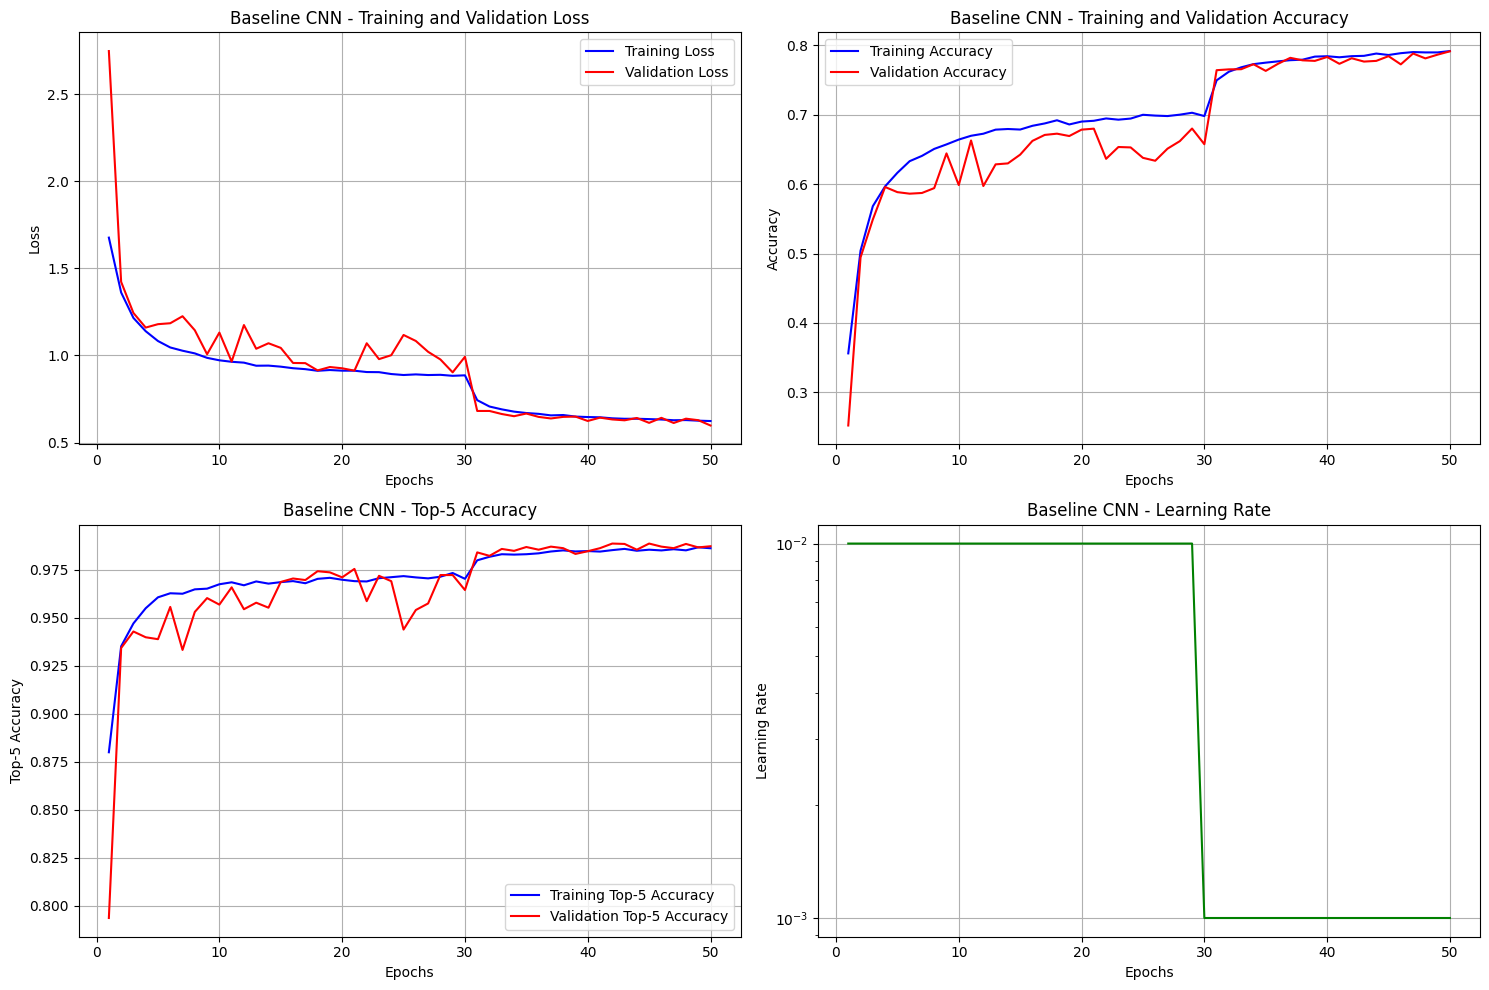

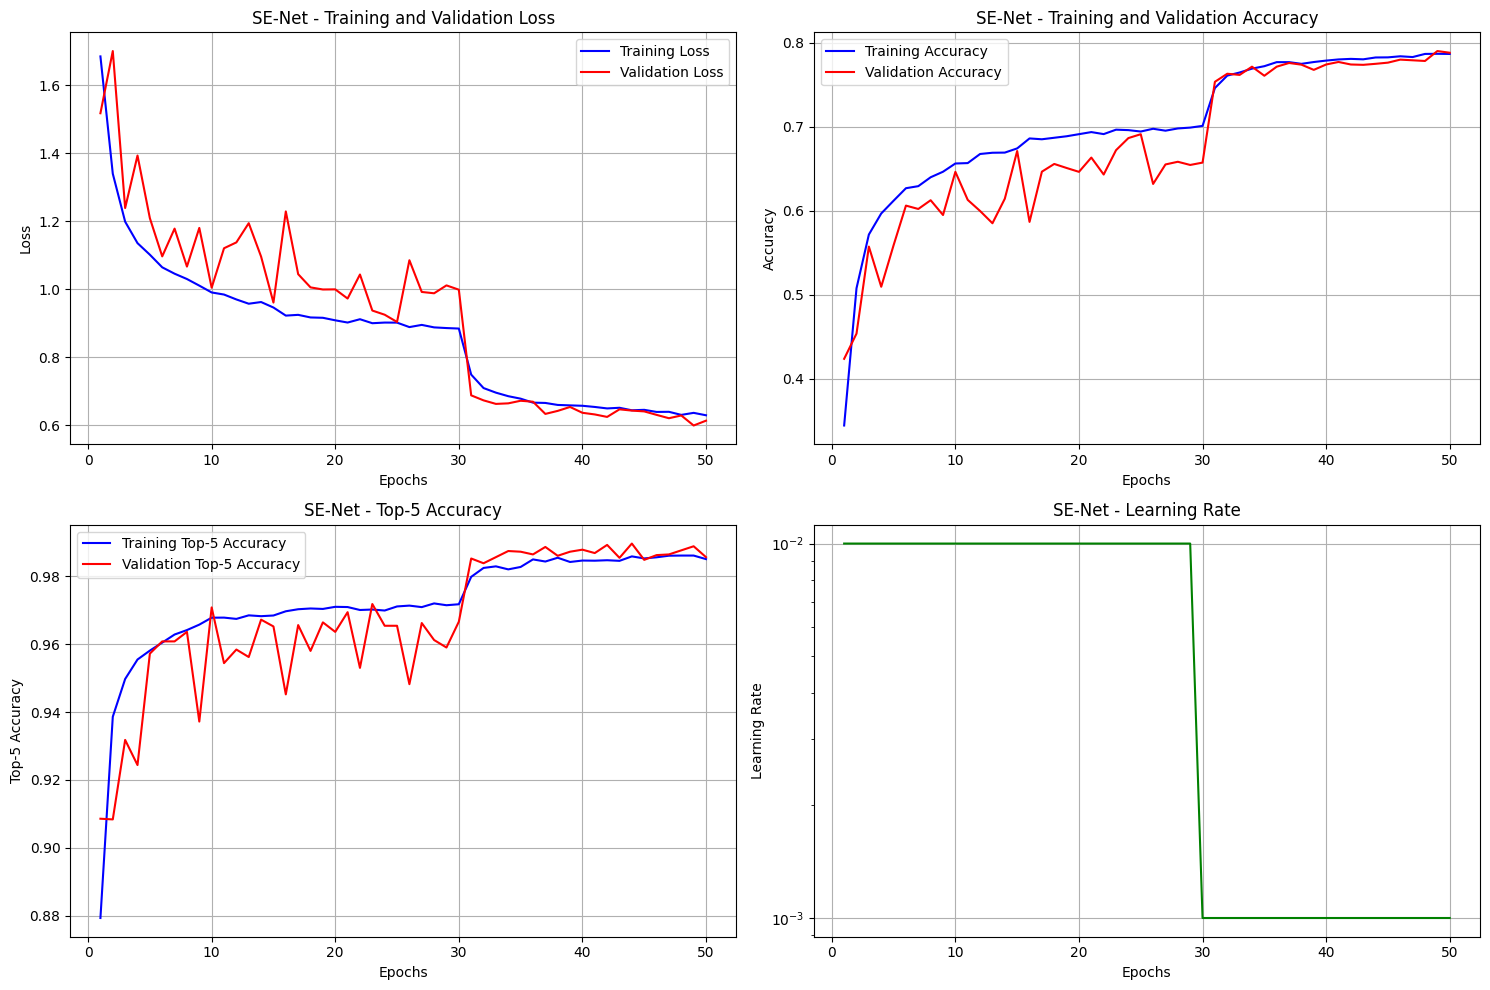

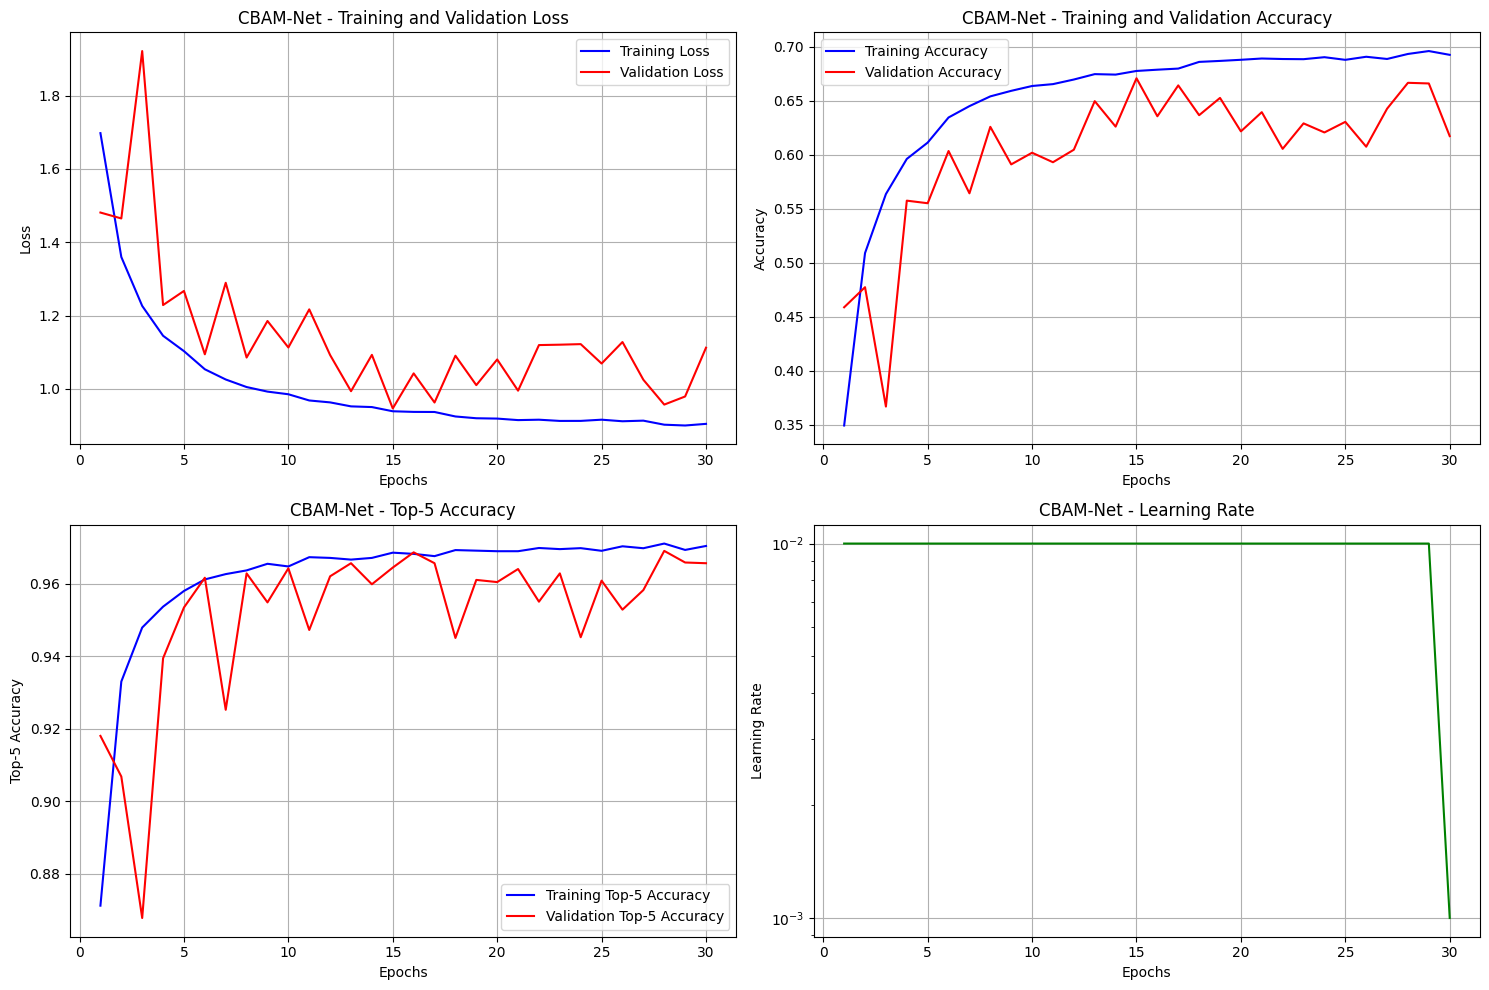

ValueError: x and y must have same first dimension, but have shapes (50,) and (30,)

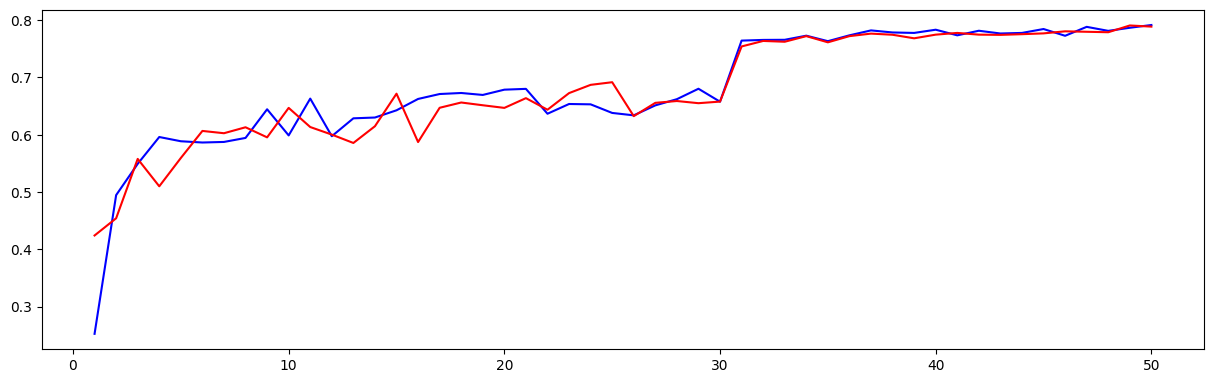

In [14]:
# Import the visualization functions we developed earlier
# from visualization import plot_training_history, compare_models

# Create basic training curves for each model
plot_training_history(baseline_history, model_name='Baseline CNN', save_path=plot_dir)
plot_training_history(se_history, model_name='SE-Net', save_path=plot_dir)
plot_training_history(cbam_history, model_name='CBAM-Net', save_path=plot_dir)

# Compare models
compare_models(
    models_history={
        'Baseline CNN': baseline_history,
        'SE-Net': se_history,
        'CBAM-Net': cbam_history
    },
    metrics=['acc', 'top5_acc', 'loss'],
    save_path=plot_dir
)

print("Training visualization completed and saved to:", plot_dir)
print("Notebook execution completed!")